In [1]:
%run ./Definitions.ipynb
!nvidia-smi
import os

2020-01-05 23:00:45.106928
thunder  Sun Jan  5 23:00:45 2020
[0] GeForce GTX 1080 Ti | 51'C,   0 % | 10936 / 11178 MB | david(10926M)
[1] GeForce GTX 1080 Ti | 55'C,   0 % | 10936 / 11178 MB | david(10926M)
[2] GeForce GTX 1080 Ti | 60'C,  99 % | 10936 / 11178 MB | david(10926M)
[3] GeForce GTX 1080 Ti | 64'C, 100 % | 10936 / 11178 MB | david(10926M)
[4] GeForce GTX 1080 Ti | 27'C,   0 % |    10 / 11178 MB |
[5] GeForce GTX 1080 Ti | 50'C,   0 % | 10895 / 11178 MB | anthoula(10885M)
[6] GeForce GTX 1080 Ti | 54'C,   0 % | 10895 / 11178 MB | anthoula(10885M)
[7] GeForce GTX 1080 Ti | 52'C,   0 % | 10895 / 11178 MB | anthoula(10885M)


/ds/environments/python2020/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)
Using TensorFlow backend.
/ds/environments/python2020/lib/python3.7/site-packages/keras/callbacks/callbacks.py:19: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Iterable


Dataset consist of 85730 patients data with 6251 features for each patient
Function definitions executed
Definitions DONE !!

Sun Jan  5 23:01:15 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.87.01    Driver Version: 418.87.01    CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 108...  Off  | 00000000:04:00.0 Off |                  N/A |
| 37%   53C    P2   237W / 250W |  10936MiB / 11178MiB |     31%      Default |
+-------------------------------+----------------------+----------------------+
|   1  GeForce GTX 108...  Off  | 00000000:06:00.0 Off |                  N/A |
| 41%   55C    P2    94W / 250W |  10936Mi

In [2]:
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   # so the IDs match nvidia-smi
os.environ["CUDA_VISIBLE_DEVICES"] = "4"   # choose here your GPU (0-7)

import tensorflow as tf
import tensorflow.compat.v1 as tf
import keras
# from keras import backend as K
import tensorflow.python.keras.backend as K


In [3]:
img_size = 250
red_size = 224

srcpath = '/ds2/data/retina/UK_BB/UK_BB_DATA/fundus/'
funduspath_CR = DATA_dir + 'Fundus_images_250_CR/'
trainpath = funduspath_CR + 'train/'
valpath = funduspath_CR + 'val/'
testpath = funduspath_CR + 'test/'

### LOAD valid train test and validation image names 

In [4]:
valid_traindf_names = pd.read_pickle(funduspath_CR + 'valid_traindf_names.pkl')
valid_valdf_names = pd.read_pickle(funduspath_CR + 'valid_valdf_names.pkl')
valid_testdf_names = pd.read_pickle(funduspath_CR + 'valid_testdf_names.pkl')

valid_traindf_names.shape , valid_valdf_names.shape , valid_testdf_names.shape

((101834, 5), (33943, 5), (33936, 5))

In [5]:
img_size = 250
red_size = 224

srcpath = '/ds2/data/retina/UK_BB/UK_BB_DATA/fundus/'
funduspath_CR = DATA_dir + 'Fundus_images_250_CR/'
trainpath = funduspath_CR + 'train/'
valpath = funduspath_CR + 'val/'
testpath = funduspath_CR + 'test/'

## Handling Imbalanced Data sets

In [6]:
which_gt = 4 # CHANGE 1,2,3,4 implies 'GT523', 'GT19', 'GTi', 'GTu'
n_NG = 0 # non glaucoma
n_G = 0  # glaucoma

GT_dict = {1:'GT523',2:'GT19',3:'GTi',4:'GTu'}
Class = GT_dict[which_gt]
temp = valid_traindf_names[Class]
for i in range(len(temp)):
    if(temp[i] == '1'):
        n_G += 1
    else:
        n_NG += 1
        
print("No. of Glaucoma patients in training set:",n_G)
print("No. of non-Glaucoma patients in training set:",n_NG)

No. of Glaucoma patients in training set: 2379
No. of non-Glaucoma patients in training set: 99455


### 1. Over Sampling Train set

In [7]:
# Oversample the minority class

X_train = valid_traindf_names['Fundus_Filenames']
y_train = valid_traindf_names[GT_dict[which_gt]]

# Converting class values to int 1 or 0
y_train = y_train.astype(int)

# concatenate our training data back together
X = pd.concat([X_train, y_train], axis=1)

# separate minority and majority classes
not_glaucoma = X[X[Class]==0]
glaucoma = X[X[Class]==1]

# upsample minority
glaucoma_upsampled = resample(glaucoma,
                              replace=True, # sample with replacement
                              n_samples=len(not_glaucoma), # match number in majority class
                              random_state=42) # reproducible results

# combine majority and upsampled minority
upsampled = pd.concat([not_glaucoma,glaucoma_upsampled])

# shuffle upsampled dataframe for training
upsampled = upsampled.sample(frac=1)


In [8]:
X[Class].value_counts()

0    99455
1     2379
Name: GTu, dtype: int64

In [9]:
upsampled[Class].value_counts()

1    99455
0    99455
Name: GTu, dtype: int64

#### validation distribution

In [10]:
valid_valdf_names[Class].value_counts()

0    33134
1      809
Name: GTu, dtype: int64

### Oversampling minority with less imbalance - in train set
Original imbalance ratio **X-** 1:40

Imbalance ratio **up1**-1:5, **up2**-1:10, **up3**-1:20, **up4**-1:30

Balanced ratio **upsampled**-1:1

In [11]:
# upsampling minority
glaucoma_up1 = resample(glaucoma, replace=True, # sample with replacement 
                        n_samples=floor(len(not_glaucoma)/5), # match number in majority class
                        random_state=42) # reproducible results

glaucoma_up2 = resample(glaucoma, replace=True, # sample with replacement 
                        n_samples=floor(len(not_glaucoma)/10), # match number in majority class
                        random_state=42) # reproducible results

glaucoma_up3 = resample(glaucoma, replace=True, # sample with replacement 
                        n_samples=floor(len(not_glaucoma)/20), # match number in majority class
                        random_state=42) # reproducible results

glaucoma_up4 = resample(glaucoma, replace=True, # sample with replacement 
                        n_samples=floor(len(not_glaucoma)/30), # match number in majority class
                        random_state=42) # reproducible results

# combine majority and upsampled minority
up1 = pd.concat([not_glaucoma,glaucoma_up1])
up2 = pd.concat([not_glaucoma,glaucoma_up2])
up3 = pd.concat([not_glaucoma,glaucoma_up3])
up4 = pd.concat([not_glaucoma,glaucoma_up4])

# shuffle upsampled dataframe for training
up1 = up1.sample(frac=1)
up2 = up2.sample(frac=1)
up3 = up3.sample(frac=1)
up4 = up4.sample(frac=1)


In [12]:
print("up1")
print(up1[Class].value_counts())
print("up2")
print(up2[Class].value_counts())
print("up1")
print(up3[Class].value_counts())
print("up4")
print(up4[Class].value_counts())

up1
0    99455
1    19891
Name: GTu, dtype: int64
up2
0    99455
1     9945
Name: GTu, dtype: int64
up1
0    99455
1     4972
Name: GTu, dtype: int64
up4
0    99455
1     3315
Name: GTu, dtype: int64


### 2. Class weight

In [13]:
# # Setting class weight for retraining:

# # compute_class_weight('balanced', np.unique(y_train), y_train)
# class_weight = [0.5, 2] # experiment with different values
n_NG , n_G

(99455, 2379)

## Define Model and Metrics

In [14]:
# reg_values = [1e-2, 1e-3, 1e-4, 1e-5, 1e-6] # 1e-1, 
reg_value = 0.001
METRICS = [keras.metrics.BinaryAccuracy(name='Accuracy'),
           Precision, 
           Recall, 
           F1,
           keras.metrics.AUC(name='AUC')]

def mobilenet_model():       
    mobile_conv = MobileNet(weights='imagenet', include_top=False, input_shape=(red_size, red_size, 3))

    # UnFreeze last conv layer
    for layer in mobile_conv.layers[:78]:
        layer.trainable = False
    for layer in mobile_conv.layers[78:]:
        layer.trainable = True
        
    # Create the model
    model = models.Sequential()
    model.add(mobile_conv)
 
    # Add new layers
    # https://adventuresinmachinelearning.com/global-average-pooling-convolutional-neural-networks/
    model.add(layers.GlobalAveragePooling2D())
    model.add(layers.Dense(1, activation='sigmoid'))
 
    return model

### Augmentation
https://nbviewer.jupyter.org/github/aleju/imgaug-doc/blob/master/notebooks/A01%20-%20Load%20and%20Augment%20an%20Image.ipynb

In [15]:
seq = iaa.Sequential([
    iaa.Fliplr(0.5),
    iaa.Affine(scale=1.1),
    iaa.Affine(rotate=(-10, 10)),
    # iaa.GammaContrast(0.9),
    iaa.Resize({"height": 230, "width": 230}),
    iaa.CropToFixedSize(width=red_size, height=red_size)
    ])

### Flow from Dataframe
https://www.kaggle.com/dmitrypukhov/cnn-with-imagedatagenerator-flow-from-dataframe

Normalizing using ImageDataGenerator https://stackoverflow.com/questions/41855512/how-does-data-normalization-work-in-keras-during-prediction

### Converting the dataframe classes to integers

In [16]:
valid_traindf_names[Class] = valid_traindf_names[Class].astype(int)
valid_valdf_names[Class] = valid_valdf_names[Class].astype(int)

In [17]:
# To use same settings as mobilenet
# from keras.applications.mobilenet import preprocess_input
# train_datagen=ImageDataGenerator(preprocessing_function=preprocess_input)

train_datagen = ImageDataGenerator(preprocessing_function=seq.augment_image, samplewise_center=True,
                                   featurewise_center=True, featurewise_std_normalization=True,
                                   rescale= 1./127.5-1) 
val_datagen = ImageDataGenerator(samplewise_center=True,
                                 featurewise_center=True, featurewise_std_normalization=True,
                                 rescale=1./127.5-1)  
BATCH_SIZE = 32

print("\nOriginal imbalanced train data: ")
imb_train_generator = train_datagen.flow_from_dataframe(
    # dataframe=valid_traindf_names,
    dataframe = valid_traindf_names, # imbalanced train dataframe
    directory=trainpath,
    x_col=valid_traindf_names.columns[0],
    y_col=valid_traindf_names.columns[which_gt],
#     x_col = upsampled.columns[0], # upsampled data
#     y_col = upsampled.columns[1], # upsampled data
    class_mode="raw",
    target_size=(red_size, red_size),
    batch_size=BATCH_SIZE
)

print("\nOriginal validation data: ")
validation_generator = val_datagen.flow_from_dataframe(
    dataframe=valid_valdf_names,
    directory=valpath,
    x_col=valid_valdf_names.columns[0],
    y_col=valid_valdf_names.columns[which_gt],
    class_mode="raw",
    target_size=(red_size, red_size),
    batch_size=BATCH_SIZE
)

print("\nUpsampled train data 1:1 ")
up_train_generator = train_datagen.flow_from_dataframe(
    # dataframe=valid_traindf_names,
    dataframe = upsampled, # upsampled data
    directory=trainpath,
    # x_col=valid_traindf_names.columns[0],
    # y_col=valid_traindf_names.columns[which_gt],
    x_col = upsampled.columns[0], # upsampled data
    y_col = upsampled.columns[1], # upsampled data
    class_mode="raw",
    target_size=(red_size, red_size),
    batch_size=BATCH_SIZE
)

print("\nUP1 train data 1:5 ")
up1_train_generator = train_datagen.flow_from_dataframe(
    # dataframe=valid_traindf_names,
    dataframe = up1, # upsampled data
    directory=trainpath,
    # x_col=valid_traindf_names.columns[0],
    # y_col=valid_traindf_names.columns[which_gt],
    x_col = up1.columns[0], # upsampled data
    y_col = up1.columns[1], # upsampled data
    class_mode="raw",
    target_size=(red_size, red_size),
    batch_size=BATCH_SIZE
)

print("\nUP2 train data 1:10 ")
up2_train_generator = train_datagen.flow_from_dataframe(
    # dataframe=valid_traindf_names,
    dataframe = up2, # upsampled data
    directory=trainpath,
    # x_col=valid_traindf_names.columns[0],
    # y_col=valid_traindf_names.columns[which_gt],
    x_col = up2.columns[0], # upsampled data
    y_col = up2.columns[1], # upsampled data
    class_mode="raw",
    target_size=(red_size, red_size),
    batch_size=BATCH_SIZE
)

print("\nUP3 train data 1:20 ")
up3_train_generator = train_datagen.flow_from_dataframe(
    # dataframe=valid_traindf_names,
    dataframe = up3, # upsampled data
    directory=trainpath,
    # x_col=valid_traindf_names.columns[0],
    # y_col=valid_traindf_names.columns[which_gt],
    x_col = up3.columns[0], # upsampled data
    y_col = up3.columns[1], # upsampled data
    class_mode="raw",
    target_size=(red_size, red_size),
    batch_size=BATCH_SIZE
)

print("\nUP4 train data 1:30 ")
up4_train_generator = train_datagen.flow_from_dataframe(
    # dataframe=valid_traindf_names,
    dataframe = up4, # upsampled data
    directory=trainpath,
    # x_col=valid_traindf_names.columns[0],
    # y_col=valid_traindf_names.columns[which_gt],
    x_col = up4.columns[0], # upsampled data
    y_col = up4.columns[1], # upsampled data
    class_mode="raw",
    target_size=(red_size, red_size),
    batch_size=BATCH_SIZE
)



Original imbalanced train data: 
Found 101834 validated image filenames.

Original validation data: 
Found 33943 validated image filenames.

Upsampled train data 1:1 
Found 198910 validated image filenames.

UP1 train data 1:5 
Found 119346 validated image filenames.

UP2 train data 1:10 
Found 109400 validated image filenames.

UP3 train data 1:20 
Found 104427 validated image filenames.

UP4 train data 1:30 
Found 102770 validated image filenames.


### Choosing parameters and model compile

In [18]:
which_model = mobilenet_model
# which_model = vgg_model

model = which_model()
learning_rate  = 0.0001 
decay = 1e-5
momentum=0.9
opt = Adam(lr=learning_rate, decay = decay) 
model.compile(loss='binary_crossentropy', metrics=METRICS, optimizer=opt)
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenet_1.00_224 (Model)   (None, 7, 7, 1024)        3228864   
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 1025      
Total params: 3,229,889
Trainable params: 1,589,249
Non-trainable params: 1,640,640
_________________________________________________________________


In [19]:
# With L2 weight regularizer
# es = EarlyStopping(monitor='val_loss', patience=5, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, min_lr=0.000001, verbose=1)
n_epochs=200
n_steps_per_epoch = 50
n_validation_steps = 10

### Train with upsampled data (1:1)

In [20]:
# start = time.time()
# up_history = model.fit_generator(up_train_generator, 
#                               epochs=n_epochs, 
#                               steps_per_epoch=n_steps_per_epoch,
#                               validation_data=validation_generator,
#                               validation_steps=n_validation_steps, 
#                               callbacks=[reduce_lr]
#                              )
# end = time.time()

In [21]:
# print("Time taken:",end-start)

In [22]:
# plt.figure(figsize=(10,10))
# plot_metrics(up_history)

### Train with UP2 (1:10)

In [23]:
# start = time.time()
# up2_history = model.fit_generator(up2_train_generator, 
#                               epochs=n_epochs, 
#                               steps_per_epoch=n_steps_per_epoch,
#                               validation_data=validation_generator,
#                               validation_steps=n_validation_steps,
#                               class_weight = [1.5,0.5],
#                               callbacks=[reduce_lr]
#                              )
# end = time.time()

In [24]:
# print("Time taken:",end-start)

In [25]:
# plt.figure(figsize=(10,10))
# plot_metrics(up2_history)

### Train with UP3 (1:20)

In [26]:
start = time.time()
up3_history = model.fit_generator(up3_train_generator, 
                              epochs=n_epochs, 
                              steps_per_epoch=n_steps_per_epoch,
                              validation_data=validation_generator,
                              validation_steps=n_validation_steps, 
                              class_weight = {0:0.5,1:2},
                              callbacks=[reduce_lr]
                             )
end = time.time()

/ds/environments/python2020/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:339: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  if not isinstance(values, collections.Sequence):


Epoch 1/200


/ds/environments/python2020/lib/python3.7/site-packages/keras_preprocessing/image/image_data_generator.py:716: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/ds/environments/python2020/lib/python3.7/site-packages/keras_preprocessing/image/image_data_generator.py:724: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


50/50 [==============================] - 32s 646ms/step - loss: 0.3510 - Accuracy: 0.7506 - Precision: 0.0748 - Recall: 0.2267 - F1: 0.0917 - AUC: 0.5625 - val_loss: 1.3194 - val_Accuracy: 0.0719 - val_Precision: 0.0354 - val_Recall: 0.7000 - val_F1: 0.0668 - val_AUC: 0.5056
Epoch 2/200
50/50 [==============================] - 22s 449ms/step - loss: 0.2834 - Accuracy: 0.9031 - Precision: 0.0440 - Recall: 0.0467 - F1: 0.0404 - AUC: 0.5971 - val_loss: 0.3033 - val_Accuracy: 0.9719 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_F1: 0.0000e+00 - val_AUC: 0.6322
Epoch 3/200
50/50 [==============================] - 23s 468ms/step - loss: 0.2733 - Accuracy: 0.9287 - Precision: 0.0300 - Recall: 0.0250 - F1: 0.0213 - AUC: 0.6356 - val_loss: 2.3976 - val_Accuracy: 0.0188 - val_Precision: 0.0156 - val_Recall: 0.4000 - val_F1: 0.0299 - val_AUC: 0.3879
Epoch 4/200
50/50 [==============================] - 23s 467ms/step - loss: 0.2544 - Accuracy: 0.9206 - Precision: 0.0913 - Recall: 0.09

Epoch 29/200
50/50 [==============================] - 26s 514ms/step - loss: 0.2398 - Accuracy: 0.9337 - Precision: 0.1450 - Recall: 0.1617 - F1: 0.1417 - AUC: 0.7104 - val_loss: 1.2746 - val_Accuracy: 0.1281 - val_Precision: 0.0244 - val_Recall: 0.4750 - val_F1: 0.0453 - val_AUC: 0.3548
Epoch 30/200
50/50 [==============================] - 28s 561ms/step - loss: 0.2135 - Accuracy: 0.9469 - Precision: 0.1100 - Recall: 0.0600 - F1: 0.0670 - AUC: 0.7589 - val_loss: 1.3029 - val_Accuracy: 0.0688 - val_Precision: 0.0133 - val_Recall: 0.3000 - val_F1: 0.0254 - val_AUC: 0.5000
Epoch 31/200
50/50 [==============================] - 27s 545ms/step - loss: 0.2816 - Accuracy: 0.9306 - Precision: 0.1183 - Recall: 0.0849 - F1: 0.0917 - AUC: 0.6772 - val_loss: 1.2156 - val_Accuracy: 0.1375 - val_Precision: 0.0276 - val_Recall: 0.5000 - val_F1: 0.0518 - val_AUC: 0.6440
Epoch 32/200
50/50 [==============================] - 28s 552ms/step - loss: 0.2230 - Accuracy: 0.9438 - Precision: 0.1433 - Recall: 

50/50 [==============================] - 26s 518ms/step - loss: 0.2213 - Accuracy: 0.9456 - Precision: 0.1400 - Recall: 0.1083 - F1: 0.1114 - AUC: 0.7179 - val_loss: 1.3614 - val_Accuracy: 0.1344 - val_Precision: 0.0313 - val_Recall: 0.6000 - val_F1: 0.0593 - val_AUC: 0.6306
Epoch 58/200
50/50 [==============================] - 25s 496ms/step - loss: 0.2132 - Accuracy: 0.9475 - Precision: 0.2133 - Recall: 0.1667 - F1: 0.1744 - AUC: 0.7653 - val_loss: 1.2998 - val_Accuracy: 0.1187 - val_Precision: 0.0305 - val_Recall: 0.5000 - val_F1: 0.0570 - val_AUC: 0.7451
Epoch 59/200
50/50 [==============================] - 25s 500ms/step - loss: 0.2284 - Accuracy: 0.9369 - Precision: 0.1983 - Recall: 0.1087 - F1: 0.1313 - AUC: 0.7669 - val_loss: 1.1239 - val_Accuracy: 0.1437 - val_Precision: 0.0419 - val_Recall: 0.6500 - val_F1: 0.0774 - val_AUC: 0.5383
Epoch 60/200
50/50 [==============================] - 26s 519ms/step - loss: 0.2286 - Accuracy: 0.9444 - Precision: 0.1350 - Recall: 0.0950 - F1: 

50/50 [==============================] - 32s 644ms/step - loss: 0.1961 - Accuracy: 0.9494 - Precision: 0.1700 - Recall: 0.0917 - F1: 0.1100 - AUC: 0.7708 - val_loss: 1.0328 - val_Accuracy: 0.1031 - val_Precision: 0.0111 - val_Recall: 0.2000 - val_F1: 0.0209 - val_AUC: 0.2415
Epoch 86/200
50/50 [==============================] - 33s 669ms/step - loss: 0.2110 - Accuracy: 0.9475 - Precision: 0.0700 - Recall: 0.0417 - F1: 0.0500 - AUC: 0.7566 - val_loss: 1.1318 - val_Accuracy: 0.1219 - val_Precision: 0.0175 - val_Recall: 0.4000 - val_F1: 0.0335 - val_AUC: 0.6848
Epoch 87/200
50/50 [==============================] - 27s 543ms/step - loss: 0.2199 - Accuracy: 0.9488 - Precision: 0.2300 - Recall: 0.1550 - F1: 0.1767 - AUC: 0.7436 - val_loss: 1.3104 - val_Accuracy: 0.0969 - val_Precision: 0.0066 - val_Recall: 0.1500 - val_F1: 0.0125 - val_AUC: 0.4732
Epoch 88/200
50/50 [==============================] - 28s 551ms/step - loss: 0.2181 - Accuracy: 0.9394 - Precision: 0.0867 - Recall: 0.0917 - F1: 

50/50 [==============================] - 37s 738ms/step - loss: 0.2316 - Accuracy: 0.9388 - Precision: 0.1967 - Recall: 0.1473 - F1: 0.1624 - AUC: 0.7629 - val_loss: 1.1851 - val_Accuracy: 0.1031 - val_Precision: 0.0210 - val_Recall: 0.4000 - val_F1: 0.0392 - val_AUC: 0.6913
Epoch 114/200
50/50 [==============================] - 37s 744ms/step - loss: 0.2079 - Accuracy: 0.9444 - Precision: 0.1700 - Recall: 0.1067 - F1: 0.1233 - AUC: 0.7606 - val_loss: 1.1043 - val_Accuracy: 0.1187 - val_Precision: 0.0145 - val_Recall: 0.3000 - val_F1: 0.0273 - val_AUC: 0.3032
Epoch 115/200
50/50 [==============================] - 37s 749ms/step - loss: 0.2088 - Accuracy: 0.9544 - Precision: 0.1850 - Recall: 0.1433 - F1: 0.1513 - AUC: 0.7649 - val_loss: 1.1920 - val_Accuracy: 0.1312 - val_Precision: 0.0278 - val_Recall: 0.6500 - val_F1: 0.0532 - val_AUC: 0.5259
Epoch 116/200
50/50 [==============================] - 29s 583ms/step - loss: 0.2127 - Accuracy: 0.9388 - Precision: 0.1750 - Recall: 0.1367 - F

50/50 [==============================] - 29s 581ms/step - loss: 0.2012 - Accuracy: 0.9488 - Precision: 0.0667 - Recall: 0.0900 - F1: 0.0700 - AUC: 0.7502 - val_loss: 1.1758 - val_Accuracy: 0.1187 - val_Precision: 0.0173 - val_Recall: 0.4500 - val_F1: 0.0332 - val_AUC: 0.5236
Epoch 142/200
50/50 [==============================] - 26s 529ms/step - loss: 0.2023 - Accuracy: 0.9550 - Precision: 0.2367 - Recall: 0.1947 - F1: 0.1974 - AUC: 0.7694 - val_loss: 1.0737 - val_Accuracy: 0.1156 - val_Precision: 0.0283 - val_Recall: 0.3667 - val_F1: 0.0518 - val_AUC: 0.7744
Epoch 143/200
50/50 [==============================] - 28s 561ms/step - loss: 0.2189 - Accuracy: 0.9488 - Precision: 0.2067 - Recall: 0.1300 - F1: 0.1447 - AUC: 0.7794 - val_loss: 1.2129 - val_Accuracy: 0.0938 - val_Precision: 0.0239 - val_Recall: 0.6500 - val_F1: 0.0460 - val_AUC: 0.4649
Epoch 144/200
50/50 [==============================] - 27s 532ms/step - loss: 0.1990 - Accuracy: 0.9463 - Precision: 0.1600 - Recall: 0.1007 - F

50/50 [==============================] - 23s 462ms/step - loss: 0.2170 - Accuracy: 0.9468 - Precision: 0.1567 - Recall: 0.1300 - F1: 0.1293 - AUC: 0.7382 - val_loss: 1.1791 - val_Accuracy: 0.1344 - val_Precision: 0.0137 - val_Recall: 0.4000 - val_F1: 0.0265 - val_AUC: 0.4165
Epoch 170/200
50/50 [==============================] - 29s 573ms/step - loss: 0.2088 - Accuracy: 0.9488 - Precision: 0.1400 - Recall: 0.0873 - F1: 0.1050 - AUC: 0.7819 - val_loss: 1.1563 - val_Accuracy: 0.1500 - val_Precision: 0.0255 - val_Recall: 0.6000 - val_F1: 0.0488 - val_AUC: 0.4498
Epoch 171/200
50/50 [==============================] - 30s 600ms/step - loss: 0.1974 - Accuracy: 0.9494 - Precision: 0.1300 - Recall: 0.1450 - F1: 0.1267 - AUC: 0.7728 - val_loss: 1.1964 - val_Accuracy: 0.1281 - val_Precision: 0.0279 - val_Recall: 0.5000 - val_F1: 0.0513 - val_AUC: 0.6420
Epoch 172/200
50/50 [==============================] - 29s 576ms/step - loss: 0.2209 - Accuracy: 0.9450 - Precision: 0.1800 - Recall: 0.1533 - F

50/50 [==============================] - 22s 446ms/step - loss: 0.2250 - Accuracy: 0.9344 - Precision: 0.1633 - Recall: 0.0790 - F1: 0.1007 - AUC: 0.7971 - val_loss: 1.2230 - val_Accuracy: 0.1125 - val_Precision: 0.0287 - val_Recall: 0.2800 - val_F1: 0.0507 - val_AUC: 0.4668
Epoch 198/200
50/50 [==============================] - 23s 458ms/step - loss: 0.1992 - Accuracy: 0.9475 - Precision: 0.2033 - Recall: 0.1483 - F1: 0.1607 - AUC: 0.8004 - val_loss: 1.1584 - val_Accuracy: 0.1281 - val_Precision: 0.0212 - val_Recall: 0.4000 - val_F1: 0.0397 - val_AUC: 0.5547
Epoch 199/200
50/50 [==============================] - 25s 503ms/step - loss: 0.2192 - Accuracy: 0.9394 - Precision: 0.1200 - Recall: 0.0913 - F1: 0.0914 - AUC: 0.7691 - val_loss: 1.1751 - val_Accuracy: 0.1187 - val_Precision: 0.0146 - val_Recall: 0.4000 - val_F1: 0.0281 - val_AUC: 0.3604
Epoch 200/200
50/50 [==============================] - 27s 534ms/step - loss: 0.2061 - Accuracy: 0.9469 - Precision: 0.1300 - Recall: 0.0883 - F

In [27]:
print("Time taken:",end-start)

Time taken: 5780.653753995895


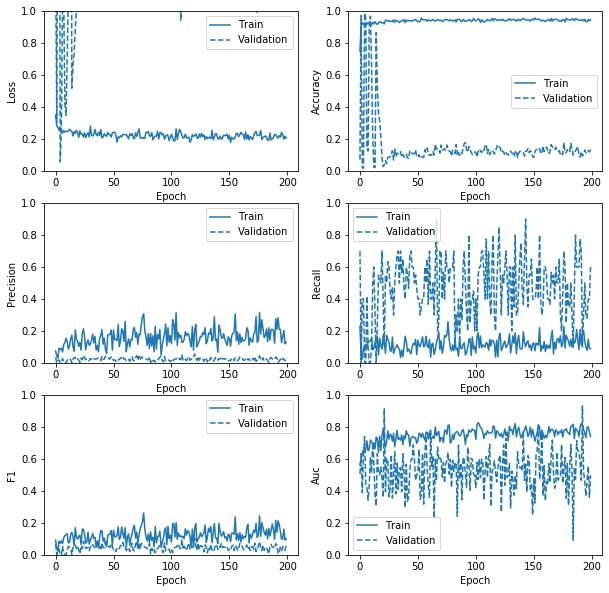

In [28]:
plt.figure(figsize=(10,10))
plot_metrics(up3_history)

### Train with UP4 (1:30)

In [29]:
# start = time.time()
# up4_history = model.fit_generator(up4_train_generator, 
#                               epochs=n_epochs, 
#                               steps_per_epoch=n_steps_per_epoch,
#                               validation_data=validation_generator,
#                               validation_steps=n_validation_steps, 
#                               callbacks=[reduce_lr]
#                              )
# end = time.time()

In [30]:
# print("Time taken:",end-start)

In [31]:
# plt.figure(figsize=(10,10))
# plot_metrics(up4_history)

### Train with Imbalanced original train data (1:40)

In [32]:
start = time.time()
imb_history = model.fit_generator(imb_train_generator,
                                  epochs=n_epochs,
                                  steps_per_epoch=n_steps_per_epoch,
                                  validation_data=validation_generator,
                                  validation_steps=n_validation_steps,
                                  class_weight = {0:0.5,1:4},
                                  callbacks=[reduce_lr]
                                 )
end = time.time()

Epoch 1/200
50/50 [==============================] - 32s 643ms/step - loss: 0.2259 - Accuracy: 0.9588 - Precision: 0.0000e+00 - Recall: 0.0000e+00 - F1: 0.0000e+00 - AUC: 0.7172 - val_loss: 1.0701 - val_Accuracy: 0.1469 - val_Precision: 0.0355 - val_Recall: 0.7000 - val_F1: 0.0673 - val_AUC: 0.5471
Epoch 2/200
50/50 [==============================] - 32s 634ms/step - loss: 0.1921 - Accuracy: 0.9669 - Precision: 0.1000 - Recall: 0.0900 - F1: 0.0933 - AUC: 0.7698 - val_loss: 1.1402 - val_Accuracy: 0.0906 - val_Precision: 0.0209 - val_Recall: 0.5000 - val_F1: 0.0399 - val_AUC: 0.3616
Epoch 3/200
50/50 [==============================] - 30s 592ms/step - loss: 0.2289 - Accuracy: 0.9631 - Precision: 0.1100 - Recall: 0.0867 - F1: 0.0900 - AUC: 0.7676 - val_loss: 1.1452 - val_Accuracy: 0.1594 - val_Precision: 0.0243 - val_Recall: 0.5000 - val_F1: 0.0461 - val_AUC: 0.5038
Epoch 4/200
50/50 [==============================] - 31s 613ms/step - loss: 0.2895 - Accuracy: 0.9606 - Precision: 0.0200 - 

50/50 [==============================] - 27s 538ms/step - loss: 0.2224 - Accuracy: 0.9650 - Precision: 0.0300 - Recall: 0.0200 - F1: 0.0233 - AUC: 0.7237 - val_loss: 1.1176 - val_Accuracy: 0.1562 - val_Precision: 0.0388 - val_Recall: 0.8000 - val_F1: 0.0735 - val_AUC: 0.5315
Epoch 30/200
50/50 [==============================] - 26s 530ms/step - loss: 0.1932 - Accuracy: 0.9706 - Precision: 0.0600 - Recall: 0.0600 - F1: 0.0600 - AUC: 0.7514 - val_loss: 1.1323 - val_Accuracy: 0.1469 - val_Precision: 0.0073 - val_Recall: 0.2000 - val_F1: 0.0140 - val_AUC: 0.2264
Epoch 31/200
50/50 [==============================] - 26s 523ms/step - loss: 0.2454 - Accuracy: 0.9575 - Precision: 0.1000 - Recall: 0.0667 - F1: 0.0780 - AUC: 0.7781 - val_loss: 1.2434 - val_Accuracy: 0.0938 - val_Precision: 0.0105 - val_Recall: 0.3000 - val_F1: 0.0202 - val_AUC: 0.6377
Epoch 32/200
50/50 [==============================] - 24s 486ms/step - loss: 0.2534 - Accuracy: 0.9638 - Precision: 0.1000 - Recall: 0.0817 - F1: 

50/50 [==============================] - 42s 838ms/step - loss: 0.2267 - Accuracy: 0.9688 - Precision: 0.0600 - Recall: 0.0467 - F1: 0.0467 - AUC: 0.7091 - val_loss: 1.2363 - val_Accuracy: 0.1406 - val_Precision: 0.0207 - val_Recall: 0.5000 - val_F1: 0.0397 - val_AUC: 0.4205
Epoch 58/200
50/50 [==============================] - 44s 877ms/step - loss: 0.1893 - Accuracy: 0.9700 - Precision: 0.1000 - Recall: 0.1100 - F1: 0.1000 - AUC: 0.7765 - val_loss: 1.1712 - val_Accuracy: 0.1187 - val_Precision: 0.0176 - val_Recall: 0.4000 - val_F1: 0.0336 - val_AUC: 0.6981
Epoch 59/200
50/50 [==============================] - 40s 798ms/step - loss: 0.2469 - Accuracy: 0.9619 - Precision: 0.0200 - Recall: 0.0200 - F1: 0.0200 - AUC: 0.7217 - val_loss: 1.1668 - val_Accuracy: 0.1219 - val_Precision: 0.0275 - val_Recall: 0.4667 - val_F1: 0.0512 - val_AUC: 0.3965
Epoch 60/200
50/50 [==============================] - 36s 719ms/step - loss: 0.2226 - Accuracy: 0.9681 - Precision: 0.1300 - Recall: 0.1200 - F1: 

50/50 [==============================] - 37s 733ms/step - loss: 0.2343 - Accuracy: 0.9606 - Precision: 0.0900 - Recall: 0.0750 - F1: 0.0747 - AUC: 0.7221 - val_loss: 1.0409 - val_Accuracy: 0.1063 - val_Precision: 0.0381 - val_Recall: 0.7750 - val_F1: 0.0714 - val_AUC: 0.5699
Epoch 86/200
50/50 [==============================] - 40s 802ms/step - loss: 0.2784 - Accuracy: 0.9581 - Precision: 0.0400 - Recall: 0.0400 - F1: 0.0400 - AUC: 0.6839 - val_loss: 1.0972 - val_Accuracy: 0.1250 - val_Precision: 0.0279 - val_Recall: 0.6500 - val_F1: 0.0532 - val_AUC: 0.4719
Epoch 87/200
50/50 [==============================] - 38s 756ms/step - loss: 0.2106 - Accuracy: 0.9631 - Precision: 0.0800 - Recall: 0.0700 - F1: 0.0733 - AUC: 0.8401 - val_loss: 1.0876 - val_Accuracy: 0.1094 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_F1: 0.0000e+00 - val_AUC: 0.0000e+00
Epoch 88/200
50/50 [==============================] - 36s 720ms/step - loss: 0.2149 - Accuracy: 0.9600 - Precision: 0.0600 - Recal

50/50 [==============================] - 37s 740ms/step - loss: 0.2402 - Accuracy: 0.9644 - Precision: 0.0567 - Recall: 0.0467 - F1: 0.0493 - AUC: 0.6811 - val_loss: 1.1275 - val_Accuracy: 0.1187 - val_Precision: 0.0308 - val_Recall: 0.7000 - val_F1: 0.0588 - val_AUC: 0.5805
Epoch 114/200
50/50 [==============================] - 37s 744ms/step - loss: 0.2164 - Accuracy: 0.9650 - Precision: 0.1100 - Recall: 0.1100 - F1: 0.1067 - AUC: 0.7512 - val_loss: 1.2382 - val_Accuracy: 0.1344 - val_Precision: 0.0416 - val_Recall: 0.5600 - val_F1: 0.0762 - val_AUC: 0.4820
Epoch 115/200
50/50 [==============================] - 35s 705ms/step - loss: 0.2089 - Accuracy: 0.9712 - Precision: 0.0800 - Recall: 0.0433 - F1: 0.0547 - AUC: 0.7609 - val_loss: 1.2194 - val_Accuracy: 0.1344 - val_Precision: 0.0238 - val_Recall: 0.3000 - val_F1: 0.0433 - val_AUC: 0.6901
Epoch 116/200
50/50 [==============================] - 39s 775ms/step - loss: 0.2525 - Accuracy: 0.9569 - Precision: 0.0700 - Recall: 0.0533 - F

50/50 [==============================] - 49s 971ms/step - loss: 0.2212 - Accuracy: 0.9613 - Precision: 0.0500 - Recall: 0.0467 - F1: 0.0433 - AUC: 0.7595 - val_loss: 1.2583 - val_Accuracy: 0.1281 - val_Precision: 0.0282 - val_Recall: 0.5500 - val_F1: 0.0530 - val_AUC: 0.5347
Epoch 142/200
50/50 [==============================] - 47s 946ms/step - loss: 0.2246 - Accuracy: 0.9675 - Precision: 0.1000 - Recall: 0.0900 - F1: 0.0933 - AUC: 0.7114 - val_loss: 1.1418 - val_Accuracy: 0.1250 - val_Precision: 0.0208 - val_Recall: 0.5500 - val_F1: 0.0401 - val_AUC: 0.4459
Epoch 143/200
50/50 [==============================] - 48s 960ms/step - loss: 0.2231 - Accuracy: 0.9688 - Precision: 0.0700 - Recall: 0.0500 - F1: 0.0567 - AUC: 0.7535 - val_loss: 1.1245 - val_Accuracy: 0.1375 - val_Precision: 0.0288 - val_Recall: 0.7000 - val_F1: 0.0551 - val_AUC: 0.6500
Epoch 144/200
50/50 [==============================] - 47s 947ms/step - loss: 0.2243 - Accuracy: 0.9681 - Precision: 0.0400 - Recall: 0.0500 - F

50/50 [==============================] - 46s 922ms/step - loss: 0.1994 - Accuracy: 0.9706 - Precision: 0.0600 - Recall: 0.0367 - F1: 0.0433 - AUC: 0.7325 - val_loss: 1.1766 - val_Accuracy: 0.1937 - val_Precision: 0.0445 - val_Recall: 0.7500 - val_F1: 0.0831 - val_AUC: 0.4251
Epoch 170/200
50/50 [==============================] - 49s 976ms/step - loss: 0.2336 - Accuracy: 0.9650 - Precision: 0.1300 - Recall: 0.1133 - F1: 0.1100 - AUC: 0.7724 - val_loss: 1.2229 - val_Accuracy: 0.1437 - val_Precision: 0.0317 - val_Recall: 0.6000 - val_F1: 0.0600 - val_AUC: 0.5790
Epoch 171/200
50/50 [==============================] - 50s 1s/step - loss: 0.2781 - Accuracy: 0.9638 - Precision: 0.1000 - Recall: 0.0450 - F1: 0.0607 - AUC: 0.7164 - val_loss: 1.2010 - val_Accuracy: 0.1531 - val_Precision: 0.0323 - val_Recall: 0.6000 - val_F1: 0.0603 - val_AUC: 0.6077
Epoch 172/200
50/50 [==============================] - 49s 986ms/step - loss: 0.2328 - Accuracy: 0.9600 - Precision: 0.0300 - Recall: 0.0400 - F1: 

50/50 [==============================] - 33s 658ms/step - loss: 0.2242 - Accuracy: 0.9688 - Precision: 0.0800 - Recall: 0.0700 - F1: 0.0733 - AUC: 0.7219 - val_loss: 1.0725 - val_Accuracy: 0.0969 - val_Precision: 0.0199 - val_Recall: 0.4500 - val_F1: 0.0379 - val_AUC: 0.7236
Epoch 198/200
50/50 [==============================] - 35s 704ms/step - loss: 0.2516 - Accuracy: 0.9663 - Precision: 0.0900 - Recall: 0.0767 - F1: 0.0733 - AUC: 0.7287 - val_loss: 1.2450 - val_Accuracy: 0.1437 - val_Precision: 0.0209 - val_Recall: 0.4500 - val_F1: 0.0398 - val_AUC: 0.5274
Epoch 199/200
50/50 [==============================] - 33s 669ms/step - loss: 0.2004 - Accuracy: 0.9712 - Precision: 0.0900 - Recall: 0.0900 - F1: 0.0900 - AUC: 0.7671 - val_loss: 1.1102 - val_Accuracy: 0.1594 - val_Precision: 0.0287 - val_Recall: 0.5000 - val_F1: 0.0535 - val_AUC: 0.6066
Epoch 200/200
50/50 [==============================] - 34s 685ms/step - loss: 0.2775 - Accuracy: 0.9575 - Precision: 0.0500 - Recall: 0.0333 - F

In [33]:
print("Time taken:",end-start)

Time taken: 7409.395871400833


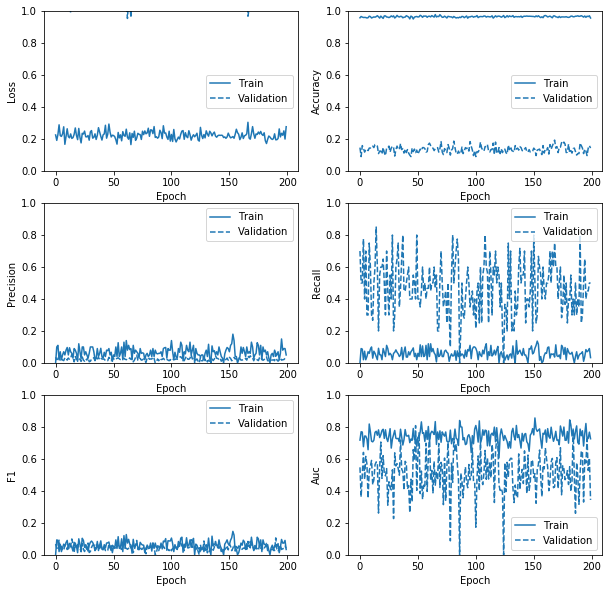

In [34]:
plt.figure(figsize=(10,10))
plot_metrics(imb_history)

## Evaluation

In [35]:
results_tr = model.evaluate(imb_train_generator,steps=100)
results_vl = model.evaluate(validation_generator,steps=100)

100/100 [==============================] - 27s 265ms/step


In [36]:
print("NAME :\tTRAIN :\tVALIDATION ")
for name, value_tr, value_vl in zip(model.metrics_names, results_tr, results_vl):
    print("%s : %5.3f : %7.3f" %(name, value_tr , value_vl))

# without classweights:
# NAME :	TRAIN :	VALIDATION 
# loss : 0.754 :   0.465
# Accuracy : 0.531 :   0.866
# Precision : 0.006 :   0.006
# Recall : 0.070 :   0.040
# F1 : 0.011 :   0.010
# AUC : 0.565 :   0.544

NAME :	TRAIN :	VALIDATION 
loss : 0.740 :   1.152
Accuracy : 0.502 :   0.141
Precision : 0.026 :   0.031
Recall : 0.260 :   0.558
F1 : 0.046 :   0.057
AUC : 0.540 :   0.549


## Prediction
The output of a binary classification is the probability of a sample belonging to a class.

In [37]:
# PREDICTED LABELS
start = time.time()
pred_tr = model.predict(imb_train_generator)
tr_end = time.time()
pred_vl = model.predict(validation_generator)
vl_end = time.time()

tr_end-start , vl_end-tr_end

(2018.824577331543, 319.2954547405243)

In [38]:
# np.save(funduspath_CR + str(n_epochs) + 'ep_traintwice_newtr.npy', pred_tr)
# np.save(funduspath_CR + str(n_epochs) + 'ep_traintwice_newvl.npy', pred_vl)

In [39]:
# val_class = []
# for i, predicted in enumerate(pred_vl):
#     if predicted[0] > 0.1:
#         #assign i to class 1
#         val_class.append(1)
#     else:
#         #assign i to class 0
#         val_class.append(0)

In [40]:
# TRUE LABELS

train_labels = valid_traindf_names[Class].tolist()
train_labels = [int(i) for i in train_labels]

val_labels = valid_valdf_names[Class].tolist()
val_labels = [int(i) for i in val_labels]


### ROC Curve

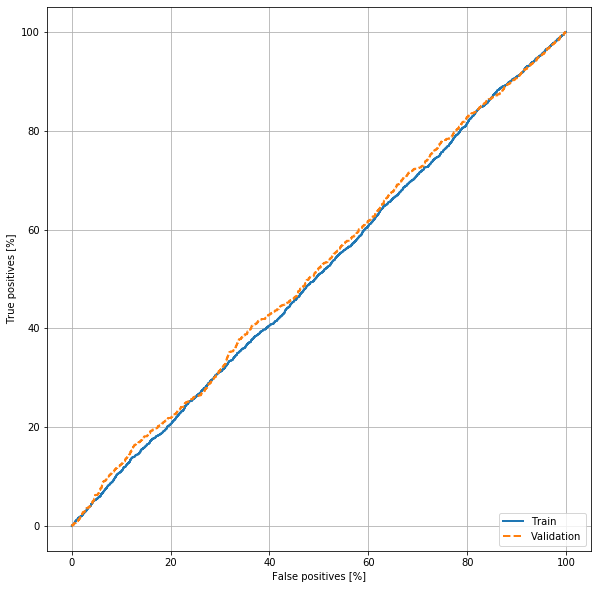

In [41]:
plt.figure(figsize=(10,10))
plot_roc("Train", train_labels, pred_tr, color=colors[0])
plot_roc("Validation", val_labels, pred_vl, color=colors[1],linestyle='--')
# plot_roc("Validation", val_labels, val_class, color=colors[3],linestyle='-.') # theshold 0.1
plt.legend(loc='lower right')

### Confusion matrix

Train data: 
TN: 50349 
FP: 49106 
FN: 1187 
TP: 1192


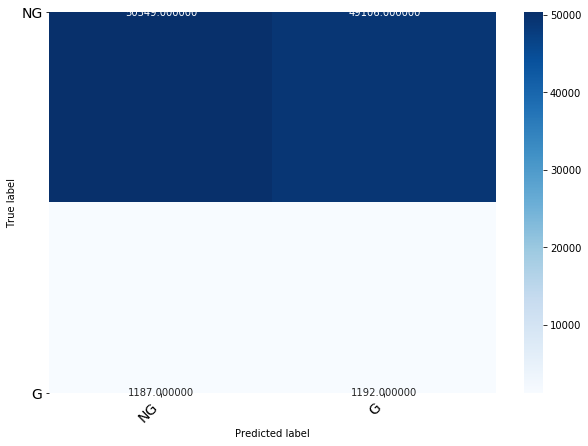

In [42]:
tn, fp, fn, tp = confusion_matrix(train_labels, pred_tr > 0.5).ravel()
train_cm = [tn, fp, fn, tp]
print("Train data: \nTN:",tn,"\nFP:",fp,"\nFN:",fn,"\nTP:",tp)
cm = confusion_matrix(train_labels, pred_tr > 0.5)
print_confusion_matrix(cm, ['NG','G'])

Validation data: 
TN: 4040 
FP: 29094 
FN: 89 
TP: 720


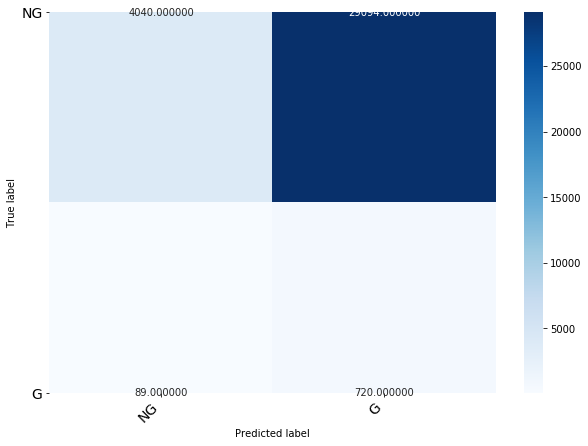

In [43]:
tn, fp, fn, tp = confusion_matrix(val_labels, pred_vl > 0.5).ravel()
val_cm = [tn, fp, fn, tp]
print("Validation data: \nTN:",tn,"\nFP:",fp,"\nFN:",fn,"\nTP:",tp)
cm = confusion_matrix(val_labels, pred_vl > 0.5)
print_confusion_matrix(cm, ['NG','G'])

### MLFlow 

In [44]:
get_notebook_name()

<IPython.core.display.Javascript object>

NameError: name 'this_notebook' is not defined

In [ ]:
# history = up3_history
# tag_value = "same as copy 6 with 1:20 and 1:40"

# exp_name = get_notebook_name()+"-run at-"+datetime.datetime.now().strftime("%d%b%Y %H:%M")
# keras_model_path = funduspath_CR+ exp_name + '_model'
# save_mlflow(keras_model_path,exp_name,which_gt,which_model,seq,BATCH_SIZE,
#             n_epochs,n_steps_per_epoch,n_validation_steps,
#             reg_value,learning_rate,decay,opt,
#             history,results_tr,results_vl,train_cm,val_cm
#            )

In [ ]:
# client = MlflowClient()
# run = client.create_run('21')
# client.set_tag(run.info.run_id, "tag_key", tag_value)